In [1]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 51.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator, Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

In [3]:
df_model = pd.read_csv('New_CONCAT.csv')

In [4]:
df_model.head()

,Molecule ChEMBL ID,Standard Value,Activity,Canon_Smiles,Unnamed: 0,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,CHEMBL599457,8350.0,0,CCCCCCCCN1C(=O)c2cccc3c(NCCN4CCN(C)CC4)ccc(c23...,0,14.431744,-4.994806,14.431744,0.887028,0.404756,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL2332018,6391.0,0,CCOC(=O)c1sc2ccccc2c1Nc1cc(OC)c(OC)c(OC)c1,1,13.313071,-3.684517,13.313071,0.093834,0.584914,...,0,0,0,0,0,0,0,1,0,0
2,CHEMBL2335485,150000.0,0,COc1cc(OC)c(-c2cc(=O)c3cc(O)ccc3o2)cc1OC,2,13.126778,-3.413073,13.126778,0.797002,0.792283,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL2335483,63670.0,0,COc1cc(OC)c(OC)cc1/C=C/C(=O)c1cc(OC(C)=O)ccc1O...,3,13.797968,-3.645201,13.797968,1.424948,0.280381,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL1928749,33760.0,0,COc1cc(OC)c(OC)cc1/C=C/C(=O)c1ccc(O)cc1O,4,13.241713,-3.472192,13.241713,0.905218,0.625426,...,0,0,0,0,0,0,0,0,0,0


In [5]:
#drop from column index 4 upward
df_model = df_model.iloc[:, :4]


In [6]:
df_model.shape

(3753, 4)

In [7]:
# Initialize Morgan fingerprint generator (radius=2, 1024 bits)
morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=1024)

In [8]:
# Get list of all available descriptor names
descriptor_names = [desc[0] for desc in Descriptors._descList]

# Create the RDKit descriptor calculator
calculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_names)

print(f"Number of RDKit descriptors: {len(descriptor_names)}")

Number of RDKit descriptors: 217


In [9]:
#function to generate Morgan fingerprints
def smiles_to_morgan_fp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None  # Invalid SMILES
    fp = morgan_gen.GetFingerprint(mol)
    return np.array(fp, dtype=np.int8)

In [10]:
# function to generate RDKit descriptors
def smiles_to_rdkit_desc(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        # Return NaNs if SMILES cannot be parsed
        return [np.nan] * len(descriptor_names)
    try:
        # Calculate all descriptors
        desc_values = calculator.CalcDescriptors(mol)
        return list(desc_values)
    except Exception as e:
        print(f"Error calculating RDKit descriptors for {smiles}: {e}")
        return [np.nan] * len(descriptor_names)


In [11]:
# Extract SMILES
smiles_series = df_model['Canon_Smiles']

print("Generating Morgan fingerprints...")
morgan_fps = smiles_series.apply(smiles_to_morgan_fp)

# Convert to DataFrame
morgan_df = pd.DataFrame(
    morgan_fps.tolist(),
    columns=[f'Morgan_{i}' for i in range(1024)],
    index=df_model.index
)

Generating Morgan fingerprints...


In [12]:
print("Generating RDKit descriptors...")

# Apply function
rdkit_descs = smiles_series.apply(smiles_to_rdkit_desc)

# Convert to DataFrame
rdkit_df = pd.DataFrame(
    rdkit_descs.tolist(),
    columns=descriptor_names,
    index=df_model.index
)

Generating RDKit descriptors...


In [13]:
# Reset index of all 3 DataFrames
df_model_reset = df_model.reset_index(drop=True)
rdkit_df_reset = rdkit_df.reset_index(drop=True)
morgan_df_reset = morgan_df.reset_index(drop=True)


In [14]:
# Combine: original df → RDKit descriptors → Morgan fingerprints
df_combined = pd.concat([df_model_reset, rdkit_df_reset, morgan_df_reset], axis=1)

In [15]:
df_combined.head()

,Molecule ChEMBL ID,Standard Value,Activity,Canon_Smiles,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,...,Morgan_1014,Morgan_1015,Morgan_1016,Morgan_1017,Morgan_1018,Morgan_1019,Morgan_1020,Morgan_1021,Morgan_1022,Morgan_1023
0,CHEMBL599457,8350.0,0,CCCCCCCCN1C(=O)c2cccc3c(NCCN4CCN(C)CC4)ccc(c23...,13.212285,13.212285,0.151625,-0.151625,0.404756,17.212121,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL2332018,6391.0,0,CCOC(=O)c1sc2ccccc2c1Nc1cc(OC)c(OC)c(OC)c1,12.450823,12.450823,0.316171,-0.353110,0.584914,10.518519,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL2335485,150000.0,0,COc1cc(OC)c(-c2cc(=O)c3cc(O)ccc3o2)cc1OC,12.334416,12.334416,0.005785,-0.264826,0.792283,10.625000,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL2335483,63670.0,0,COc1cc(OC)c(OC)cc1/C=C/C(=O)c1cc(OC(C)=O)ccc1O...,12.820184,12.820184,0.048452,-0.588124,0.280381,10.433333,...,0,0,0,1,0,0,0,0,0,0
4,CHEMBL1928749,33760.0,0,COc1cc(OC)c(OC)cc1/C=C/C(=O)c1ccc(O)cc1O,12.202139,12.202139,0.086568,-0.412650,0.625426,10.625000,...,0,0,0,0,0,0,0,0,0,0


In [16]:
df_combined.shape

(3753, 1245)

In [17]:
#columns with nan value
df_combined.columns[df_combined.isna().any()].tolist()


['MaxPartialCharge',
 'MinPartialCharge',
 'MaxAbsPartialCharge',
 'MinAbsPartialCharge',
 'BCUT2D_MWHI',
 'BCUT2D_MWLOW',
 'BCUT2D_CHGHI',
 'BCUT2D_CHGLO',
 'BCUT2D_LOGPHI',
 'BCUT2D_LOGPLOW',
 'BCUT2D_MRHI',
 'BCUT2D_MRLOW']

In [18]:
#drop columns with nan values
df_combined = df_combined.dropna(axis=1)

In [19]:
#check sum of nan
df_combined.isna().sum().sum()

np.int64(0)

In [20]:
#check columns with infinite values
df_combined.columns[df_combined.isin([np.inf, -np.inf]).any()].tolist()

[]

In [21]:
df_combined.shape

(3753, 1233)

In [22]:
#check columns with constant values
df_combined.columns[df_combined.nunique() == 1].tolist()

['NumRadicalElectrons',
 'SMR_VSA8',
 'SlogP_VSA9',
 'fr_benzodiazepine',
 'fr_diazo',
 'fr_dihydropyridine',
 'fr_isocyan',
 'fr_nitroso',
 'fr_prisulfonamd']

In [23]:
# Columns with constant values
constant_cols = [
    'NumRadicalElectrons',
    'SMR_VSA8',
    'SlogP_VSA9',
    'fr_benzodiazepine',
    'fr_diazo',
    'fr_dihydropyridine',
    'fr_isocyan',
    'fr_nitroso',
    'fr_prisulfonamd'
]

In [24]:
df_combined = df_combined.drop(columns=constant_cols, errors='ignore')

In [25]:
df_combined.shape

(3753, 1224)

In [26]:
# X is column in Index 4 and above and y is column index 2
X = df_combined.iloc[:, 4:]
y = df_combined.iloc[:, 2]


In [27]:
X.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,Morgan_1014,Morgan_1015,Morgan_1016,Morgan_1017,Morgan_1018,Morgan_1019,Morgan_1020,Morgan_1021,Morgan_1022,Morgan_1023
0,13.212285,13.212285,0.151625,-0.151625,0.404756,17.212121,450.627,412.323,450.299476,178,...,0,0,0,0,0,0,0,0,0,0
1,12.450823,12.450823,0.316171,-0.353110,0.584914,10.518519,387.457,366.289,387.114044,142,...,0,0,0,0,0,0,0,0,0,0
2,12.334416,12.334416,0.005785,-0.264826,0.792283,10.625000,328.320,312.192,328.094688,124,...,0,0,0,0,0,0,0,0,0,0
3,12.820184,12.820184,0.048452,-0.588124,0.280381,10.433333,414.410,392.234,414.131468,158,...,0,0,0,1,0,0,0,0,0,0
4,12.202139,12.202139,0.086568,-0.412650,0.625426,10.625000,330.336,312.192,330.110338,126,...,0,0,0,0,0,0,0,0,0,0


In [28]:
threshold = 1e5
X = X.loc[:, (X.abs() <= threshold).all()]

In [29]:
#remove highly correlated features in X
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
X = X.drop(to_drop, axis=1)

In [30]:
X.shape

(3753, 1172)

In [31]:
X.columns.tolist()

['MaxAbsEStateIndex',
 'MinAbsEStateIndex',
 'MinEStateIndex',
 'qed',
 'SPS',
 'MolWt',
 'FpDensityMorgan1',
 'AvgIpc',
 'BalabanJ',
 'BertzCT',
 'HallKierAlpha',
 'PEOE_VSA1',
 'PEOE_VSA10',
 'PEOE_VSA11',
 'PEOE_VSA12',
 'PEOE_VSA13',
 'PEOE_VSA14',
 'PEOE_VSA2',
 'PEOE_VSA3',
 'PEOE_VSA4',
 'PEOE_VSA5',
 'PEOE_VSA6',
 'PEOE_VSA7',
 'PEOE_VSA8',
 'PEOE_VSA9',
 'SMR_VSA1',
 'SMR_VSA10',
 'SMR_VSA2',
 'SMR_VSA3',
 'SMR_VSA4',
 'SMR_VSA5',
 'SMR_VSA6',
 'SMR_VSA7',
 'SMR_VSA9',
 'SlogP_VSA1',
 'SlogP_VSA10',
 'SlogP_VSA11',
 'SlogP_VSA12',
 'SlogP_VSA2',
 'SlogP_VSA3',
 'SlogP_VSA7',
 'SlogP_VSA8',
 'TPSA',
 'EState_VSA1',
 'EState_VSA10',
 'EState_VSA11',
 'EState_VSA2',
 'EState_VSA3',
 'EState_VSA4',
 'EState_VSA5',
 'EState_VSA6',
 'EState_VSA7',
 'EState_VSA8',
 'EState_VSA9',
 'VSA_EState1',
 'VSA_EState10',
 'VSA_EState2',
 'VSA_EState3',
 'VSA_EState4',
 'VSA_EState5',
 'VSA_EState6',
 'VSA_EState7',
 'VSA_EState8',
 'VSA_EState9',
 'FractionCSP3',
 'NHOHCount',
 'NumAliphaticC

In [32]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

# Set style for publishable plots
sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams['figure.figsize'] = (10, 6)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
X_train.shape

(3002, 1172)

In [35]:
X_test.shape

(751, 1172)

In [36]:
y_train.shape

(3002,)

In [37]:
y_test.shape

(751,)

In [38]:
# Initialize and apply the scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Define Hyperparameter Grids for RandomizedSearchCV

In [39]:
# KNN
param_dist_knn = {
    'n_neighbors': np.arange(3, 30),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Extra Trees
param_dist_et = {
    'n_estimators': np.arange(50, 500, 50),
    'max_depth': [None] + list(np.arange(5, 50, 5)),
    'min_samples_split': np.arange(2, 20),
    'min_samples_leaf': np.arange(1, 20),
    'max_features': ['sqrt', 'log2', None]
}

# LightGBM
param_dist_lgbm = {
    'num_leaves': np.arange(20, 150),
    'learning_rate': np.logspace(-3, -0.5, 50),
    'n_estimators': np.arange(50, 500, 50),
    'max_depth': np.arange(-1, 20),
    'subsample': np.linspace(0.5, 1.0, 10),
    'colsample_bytree': np.linspace(0.5, 1.0, 10)
}

Initialize Models

In [40]:
knn = KNeighborsClassifier()
et = ExtraTreesClassifier(random_state=42)
lgbm = lgb.LGBMClassifier(boosting_type='gbdt', random_state=42)

Hyperparameter Tuning with RandomizedSearchCV — KNN

In [41]:
print("Tuning KNeighborsClassifier...")
rs_knn = RandomizedSearchCV(knn, param_distributions=param_dist_knn,
                            n_iter=50, cv=5, scoring='accuracy',
                            n_jobs=-1, random_state=42, verbose=0)
rs_knn.fit(X_train_scaled, y_train)

print(f"Best KNN Params: {rs_knn.best_params_}")
print(f"Best KNN CV Score: {rs_knn.best_score_:.4f}")

model_knn = rs_knn.best_estimator_
y_pred_knn = model_knn.predict(X_test_scaled)
y_pred_proba_knn = model_knn.predict_proba(X_test_scaled)[:, 1]

Tuning KNeighborsClassifier...
Best KNN Params: {'weights': 'distance', 'n_neighbors': np.int64(7), 'metric': 'euclidean'}
Best KNN CV Score: 0.9214


Hyperparameter Tuning with RandomizedSearchCV — Extra Trees

In [42]:
print("Tuning ExtraTreesClassifier...")
rs_et = RandomizedSearchCV(et, param_distributions=param_dist_et,
                           n_iter=50, cv=5, scoring='accuracy',
                           n_jobs=-1, random_state=42, verbose=0)
rs_et.fit(X_train_scaled, y_train)

print(f"Best ExtraTrees Params: {rs_et.best_params_}")
print(f"Best ExtraTrees CV Score: {rs_et.best_score_:.4f}")

model_et = rs_et.best_estimator_
y_pred_et = model_et.predict(X_test_scaled)
y_pred_proba_et = model_et.predict_proba(X_test_scaled)[:, 1]

Tuning ExtraTreesClassifier...
Best ExtraTrees Params: {'n_estimators': np.int64(150), 'min_samples_split': np.int64(4), 'min_samples_leaf': np.int64(2), 'max_features': 'sqrt', 'max_depth': np.int64(35)}
Best ExtraTrees CV Score: 0.9287


Hyperparameter Tuning with RandomizedSearchCV — LightGBM

In [43]:
print("Tuning LightGBM Classifier...")
rs_lgbm = RandomizedSearchCV(lgbm, param_distributions=param_dist_lgbm,
                             n_iter=50, cv=5, scoring='accuracy',
                             n_jobs=-1, random_state=42, verbose=0)
rs_lgbm.fit(X_train_scaled, y_train)

print(f"Best LightGBM Params: {rs_lgbm.best_params_}")
print(f"Best LightGBM CV Score: {rs_lgbm.best_score_:.4f}")

model_lgbm = rs_lgbm.best_estimator_
y_pred_lgbm = model_lgbm.predict(X_test_scaled)
y_pred_proba_lgbm = model_lgbm.predict_proba(X_test_scaled)[:, 1]

Tuning LightGBM Classifier...
[LightGBM] [Info] Number of positive: 498, number of negative: 2504
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16491
[LightGBM] [Info] Number of data points in the train set: 3002, number of used features: 1105
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.165889 -> initscore=-1.615045
[LightGBM] [Info] Start training from score -1.615045
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

Print Metrics for All Models

In [44]:
models = {
    "KNN": (y_pred_knn, y_pred_proba_knn),
    "Extra Trees": (y_pred_et, y_pred_proba_et),
    "LightGBM": (y_pred_lgbm, y_pred_proba_lgbm)
}

print("="*60)
print("MODEL PERFORMANCE ON TEST SET")
print("="*60)

results = []

for name, (y_pred, y_pred_proba) in models.items():
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    results.append([name, acc, prec, rec])
    print(f" {name}")
    print(f"   Accuracy:  {acc:.4f}")
    print(f"   Precision: {prec:.4f}")
    print(f"   Recall:    {rec:.4f}")
    print("-"*40)

# Create results DataFrame
df_results = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall"])

MODEL PERFORMANCE ON TEST SET
 KNN
   Accuracy:  0.9294
   Precision: 0.7706
   Recall:    0.7500
----------------------------------------
 Extra Trees
   Accuracy:  0.9348
   Precision: 0.7944
   Recall:    0.7589
----------------------------------------
 LightGBM
   Accuracy:  0.9334
   Precision: 0.7870
   Recall:    0.7589
----------------------------------------


Plot Model Comparison Bar Chart

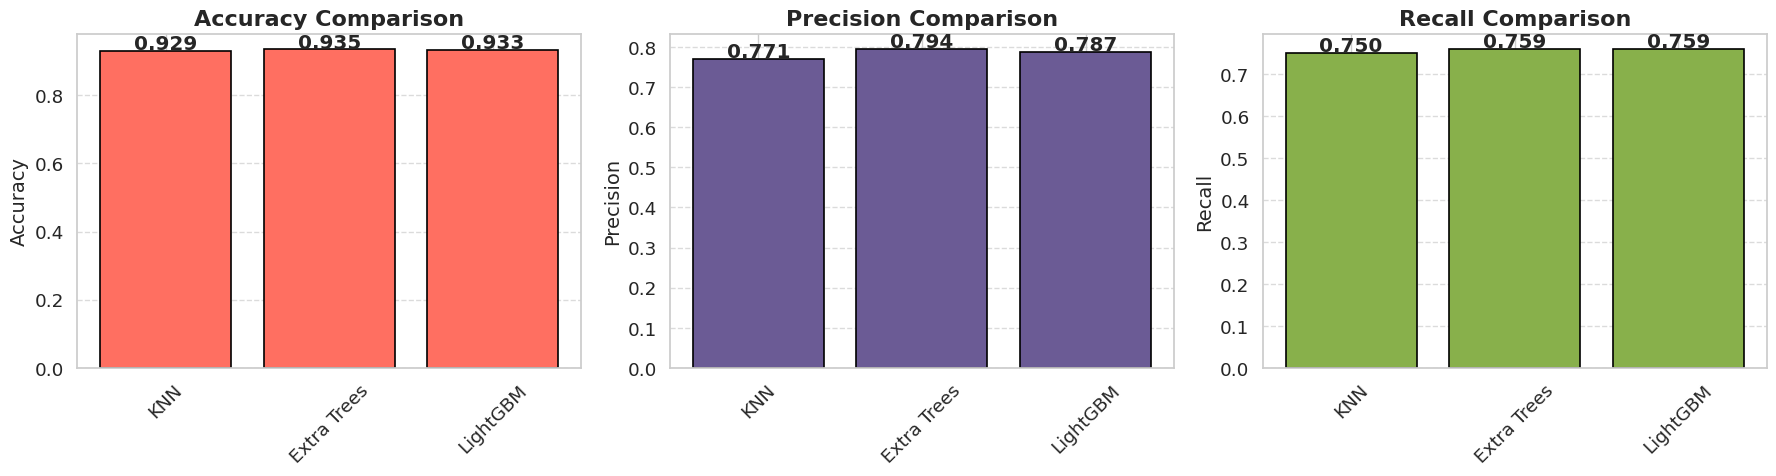

In [45]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

metrics = ["Accuracy", "Precision", "Recall"]
colors = ['#FF6F61', '#6B5B95', '#88B04B']

for i, metric in enumerate(metrics):
    ax[i].bar(df_results["Model"], df_results[metric], color=colors[i], edgecolor='black', linewidth=1.2)
    ax[i].set_title(f'{metric} Comparison', fontsize=16, fontweight='bold')
    ax[i].set_ylabel(metric, fontsize=14)
    ax[i].tick_params(axis='x', rotation=45)
    ax[i].grid(axis='y', linestyle='--', alpha=0.7)
    for j, v in enumerate(df_results[metric]):
        ax[i].text(j, v + 0.005, f"{v:.3f}", ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

Plot Confusion Matrix for Each Model

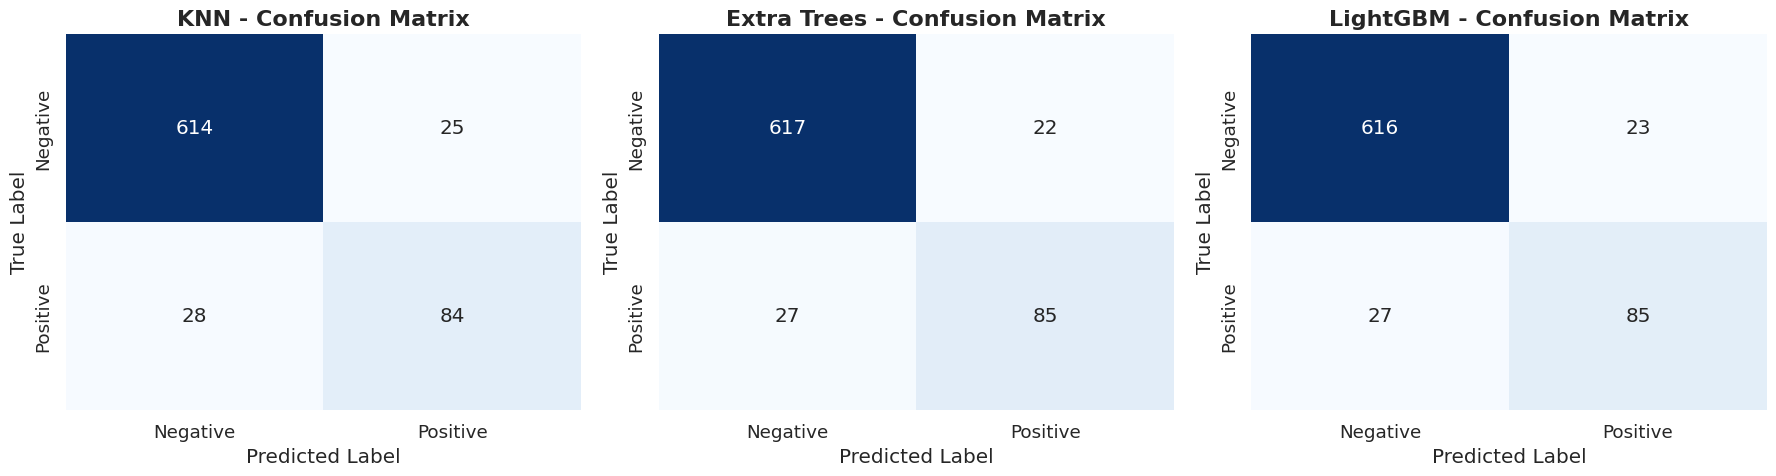

In [46]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, (y_pred, _)) in enumerate(models.items()):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'], ax=axes[idx])
    axes[idx].set_title(f'{name} - Confusion Matrix', fontsize=16, fontweight='bold')
    axes[idx].set_xlabel('Predicted Label')
    axes[idx].set_ylabel('True Label')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

Plot ROC Curves

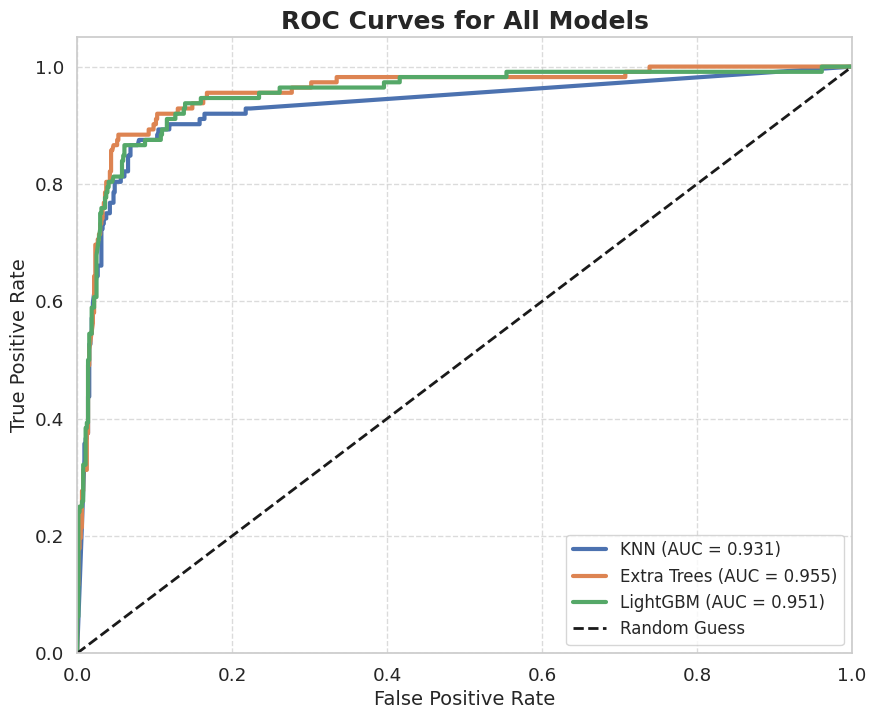

In [47]:
plt.figure(figsize=(10, 8))

for name, (_, y_pred_proba) in models.items():
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=3, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curves for All Models', fontsize=18, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

Plot Precision-Recall Curves

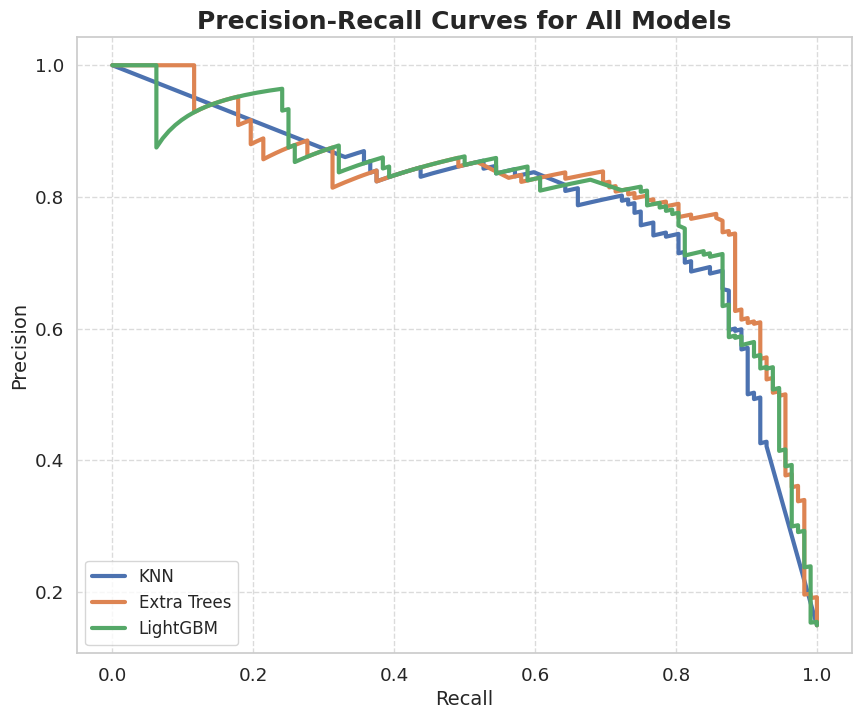

In [48]:
plt.figure(figsize=(10, 8))

for name, (_, y_pred_proba) in models.items():
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.plot(recall, precision, lw=3, label=name)

plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curves for All Models', fontsize=18, fontweight='bold')
plt.legend(loc="lower left", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('pr_curves.png', dpi=300, bbox_inches='tight')
plt.show()

In [49]:
import pickle

# Save LightGBM model
with open('lightgbm_model.pkl', 'wb') as lgbm_file:
    pickle.dump(model_lgbm, lgbm_file)

# Save Extra Trees model
with open('extratrees_model.pkl', 'wb') as extratrees_file:
    pickle.dump(model_et, extratrees_file)

# Save KNN model
with open('knn_model.pkl', 'wb') as knn_file:
    pickle.dump(model_knn, knn_file)

# Save Scaler
with open('scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

In [53]:
import pickle
import joblib

In [55]:
# Save LightGBM model
with open('lightgbm_model.pkl', 'wb') as lgbm_file:
    pickle.dump(model_lgbm, lgbm_file)

# Save Extra Trees model
with open('extratrees_model.pkl', 'wb') as extratrees_file:
    pickle.dump(model_et, extratrees_file)

# Save KNN model
with open('knn_model.pkl', 'wb') as knn_file:
    pickle.dump(model_knn, knn_file)

# Save Scaler
with open('scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

In [56]:
# Load scaler
with open('scaler.pkl', 'rb') as scaler_file:
    scaler = pickle.load(scaler_file)

# Load models
with open('lightgbm_model.pkl', 'rb') as lgbm_file:
    model_lgbm = pickle.load(lgbm_file)

with open('extratrees_model.pkl', 'rb') as extratrees_file:
    model_et = pickle.load(extratrees_file)

with open('knn_model.pkl', 'rb') as knn_file:
    model_knn = pickle.load(knn_file)

In [97]:
predict_df = pd.read_csv('Natscal1.csv')

In [98]:
predict_df.head()

,cmpdname,canonicalsmiles,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,C27H36N2O15S,CC=C(N=CS)C(=O)OC1C(COC(C)=O)OC(C2(O)CC(=O)C(N...,0.798240,0.798240,-0.410684,-0.806820,-1.461682,0.618402,0.665650,0.618443,...,-0.16963,-0.156848,-0.091114,-0.076357,-0.024495,-0.173075,0,-0.119299,0,-0.227069
1,C34H30O10,COc1cc(C)cc2c1C(=O)OC1C(O)C=CC3c4c(cc(OC)c5c4C...,1.071244,1.071244,0.658272,-0.006941,-0.670963,0.414498,0.465339,0.414566,...,-0.16963,-0.156848,-0.091114,-0.076357,-0.024495,-0.173075,0,-0.119299,0,-0.227069
2,C32H26O9,COc1cc(C)cc2c1C(=O)OC1C(O)C=CC3c4c(cc(OC)c5c4C...,0.881045,0.881045,0.258621,0.069628,-0.716461,0.269727,0.322183,0.269792,...,-0.16963,-0.156848,-0.091114,-0.076357,-0.024495,-0.173075,0,-0.119299,0,-0.227069
3,C33H42O6,CC1(C)CC2C(OC(=O)c3ccccc3)C(OC(=O)c3ccccc3)CC(...,0.705882,0.705882,0.509791,-0.861450,-0.601582,0.204468,0.193459,0.204487,...,-0.16963,-0.156848,-0.091114,-0.076357,-0.024495,-0.173075,0,-0.119299,0,-0.227069
4,C31H24O9,COc1cc(C)cc2c1C(=O)OC1C(O)C=CC3c4c(cc(O)c5c4C(...,0.817845,0.817845,0.180772,0.113618,-0.856967,0.223630,0.279219,0.223704,...,-0.16963,-0.156848,-0.091114,-0.076357,-0.024495,-0.173075,0,-0.119299,0,-0.227069


In [99]:
#drop all columns from index 2
predict_df = predict_df.drop(predict_df.columns[2:], axis=1)


In [100]:
predict_df.head()

,cmpdname,canonicalsmiles
0,C27H36N2O15S,CC=C(N=CS)C(=O)OC1C(COC(C)=O)OC(C2(O)CC(=O)C(N...
1,C34H30O10,COc1cc(C)cc2c1C(=O)OC1C(O)C=CC3c4c(cc(OC)c5c4C...
2,C32H26O9,COc1cc(C)cc2c1C(=O)OC1C(O)C=CC3c4c(cc(OC)c5c4C...
3,C33H42O6,CC1(C)CC2C(OC(=O)c3ccccc3)C(OC(=O)c3ccccc3)CC(...
4,C31H24O9,COc1cc(C)cc2c1C(=O)OC1C(O)C=CC3c4c(cc(O)c5c4C(...


In [101]:
# Extract SMILES
smiles_series_predict = predict_df['canonicalsmiles']

print("Generating Morgan fingerprints...")
morgan_fps_predict = smiles_series_predict.apply(smiles_to_morgan_fp)

# Convert to DataFrame
morgan_df_predict = pd.DataFrame(
    morgan_fps_predict.tolist(),
    columns=[f'Morgan_{i}' for i in range(1024)],
    index=smiles_series_predict.index
)

Generating Morgan fingerprints...


In [102]:
print("Generating RDKit descriptors...")

# Apply function
rdkit_descs = smiles_series_predict.apply(smiles_to_rdkit_desc)

# Convert to DataFrame
rdkit_df_predict = pd.DataFrame(
    rdkit_descs.tolist(),
    columns=descriptor_names,
    index=predict_df.index
)

Generating RDKit descriptors...


In [103]:
# Reset index of all 3 DataFrames
predict_df_reset = predict_df.reset_index(drop=True)
rdkit_df_predict_reset = rdkit_df_predict.reset_index(drop=True)
morgan_df_predict_reset = morgan_df_predict.reset_index(drop=True)

In [104]:
# Combine: original df → RDKit descriptors → Morgan fingerprints
predict_df = pd.concat([predict_df_reset, rdkit_df_predict_reset, morgan_df_predict_reset], axis=1)

In [105]:
predict_df.head()

,cmpdname,canonicalsmiles,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,...,Morgan_1014,Morgan_1015,Morgan_1016,Morgan_1017,Morgan_1018,Morgan_1019,Morgan_1020,Morgan_1021,Morgan_1022,Morgan_1023
0,C27H36N2O15S,CC=C(N=CS)C(=O)OC1C(COC(C)=O)OC(C2(O)CC(=O)C(N...,13.356117,13.356117,0.110906,-3.018916,0.036669,36.266667,660.651,624.363,...,0,0,0,1,0,1,0,0,0,0
1,C34H30O10,COc1cc(C)cc2c1C(=O)OC1C(O)C=CC3c4c(cc(OC)c5c4C...,14.572675,14.572675,0.065441,-1.335458,0.264609,25.840909,598.604,568.364,...,0,0,0,0,0,1,0,0,0,0
2,C32H26O9,COc1cc(C)cc2c1C(=O)OC1C(O)C=CC3c4c(cc(OC)c5c4C...,14.101467,14.101467,0.024437,-1.326741,0.251494,27.000000,554.551,528.343,...,0,0,0,0,0,1,0,0,0,0
3,C33H42O6,CC1(C)CC2C(OC(=O)c3ccccc3)C(OC(=O)c3ccccc3)CC(...,13.246262,13.246262,0.012318,-0.621448,0.284610,27.743590,534.693,492.357,...,0,0,0,0,0,1,0,0,0,0
4,C31H24O9,COc1cc(C)cc2c1C(=O)OC1C(O)C=CC3c4c(cc(O)c5c4C(...,13.929982,13.929982,0.001086,-1.374792,0.210990,27.450000,540.524,516.332,...,0,0,0,0,0,1,0,0,0,0


In [106]:
predict=predict_df.iloc[:,2:]

In [107]:
X_predict = predict[X.columns]

In [108]:
X_predict.shape

(10006, 1172)

In [109]:
# Scale the features using the fitted scaler
X_predict_scaled = scaler.transform(X_predict)

In [110]:
# Initialize dictionary to store predictions
predictions_dict = {
    'LightGBM_Pred': model_lgbm.predict(X_predict_scaled),
    'LightGBM_Proba': model_lgbm.predict_proba(X_predict_scaled)[:, 1],

    'ExtraTrees_Pred': model_et.predict(X_predict_scaled),
    'ExtraTrees_Proba': model_et.predict_proba(X_predict_scaled)[:, 1],

    'KNN_Pred': model_knn.predict(X_predict_scaled),
    'KNN_Proba': model_knn.predict_proba(X_predict_scaled)[:, 1],
}

# Create a DataFrame with predictions
df_predictions = pd.DataFrame(predictions_dict)

df_predictions = pd.concat([predict_df.iloc[:, :2].reset_index(drop=True), df_predictions], axis=1)

print("Predictions generated for all 3 models.")
df_predictions.head()

Predictions generated for all 3 models.


,cmpdname,canonicalsmiles,LightGBM_Pred,LightGBM_Proba,ExtraTrees_Pred,ExtraTrees_Proba,KNN_Pred,KNN_Proba
0,C27H36N2O15S,CC=C(N=CS)C(=O)OC1C(COC(C)=O)OC(C2(O)CC(=O)C(N...,0,0.034033,0,0.223956,0,0.000000
1,C34H30O10,COc1cc(C)cc2c1C(=O)OC1C(O)C=CC3c4c(cc(OC)c5c4C...,0,0.002437,0,0.163030,0,0.146328
2,C32H26O9,COc1cc(C)cc2c1C(=O)OC1C(O)C=CC3c4c(cc(OC)c5c4C...,0,0.001724,0,0.172861,0,0.144354
3,C33H42O6,CC1(C)CC2C(OC(=O)c3ccccc3)C(OC(=O)c3ccccc3)CC(...,0,0.000011,0,0.096280,0,0.000000
4,C31H24O9,COc1cc(C)cc2c1C(=O)OC1C(O)C=CC3c4c(cc(O)c5c4C(...,0,0.003269,0,0.143136,0,0.143539


Ensemble Prediction (Soft Voting)

In [111]:
#  a COPY of the original predictions to add ensemble columns
df_ensemble = df_predictions.copy()

#  ensemble probability (mean of the 3 model probabilities)
df_ensemble['Ensemble_Proba'] = df_ensemble[['LightGBM_Proba', 'ExtraTrees_Proba', 'KNN_Proba']].mean(axis=1)

# Add ensemble binary prediction (threshold = 0.5)
df_ensemble['Ensemble_Pred'] = (df_ensemble['Ensemble_Proba'] >= 0.5).astype(int)
df_ensemble.head()

,cmpdname,canonicalsmiles,LightGBM_Pred,LightGBM_Proba,ExtraTrees_Pred,ExtraTrees_Proba,KNN_Pred,KNN_Proba,Ensemble_Proba,Ensemble_Pred
0,C27H36N2O15S,CC=C(N=CS)C(=O)OC1C(COC(C)=O)OC(C2(O)CC(=O)C(N...,0,0.034033,0,0.223956,0,0.000000,0.085996,0
1,C34H30O10,COc1cc(C)cc2c1C(=O)OC1C(O)C=CC3c4c(cc(OC)c5c4C...,0,0.002437,0,0.163030,0,0.146328,0.103932,0
2,C32H26O9,COc1cc(C)cc2c1C(=O)OC1C(O)C=CC3c4c(cc(OC)c5c4C...,0,0.001724,0,0.172861,0,0.144354,0.106313,0
3,C33H42O6,CC1(C)CC2C(OC(=O)c3ccccc3)C(OC(=O)c3ccccc3)CC(...,0,0.000011,0,0.096280,0,0.000000,0.032097,0
4,C31H24O9,COc1cc(C)cc2c1C(=O)OC1C(O)C=CC3c4c(cc(O)c5c4C(...,0,0.003269,0,0.143136,0,0.143539,0.096648,0


In [112]:
# ensemble-augmented DataFrame
ensemble_output_file = 'ensemble_predictions.csv'
df_ensemble.to_csv(ensemble_output_file, index=False)

print(f"Ensemble-augmented predictions saved to '{ensemble_output_file}'")

original_output_file = 'individual_model_predictions.csv'
df_predictions.to_csv(original_output_file, index=False)

print(f"Original predictions (3 models only) saved to '{original_output_file}'")

Ensemble-augmented predictions saved to 'ensemble_predictions.csv'
Original predictions (3 models only) saved to 'individual_model_predictions.csv'


Count Active/Inactive for Each Model

In [113]:
# Initialize summary dictionary
summary_counts = {}

# Loop through each model's prediction column
for model in ['LightGBM', 'ExtraTrees', 'KNN']:
    pred_col = f'{model}_Pred'
    counts = df_predictions[pred_col].value_counts().sort_index()

    inactive_count = counts.get(0, 0)
    active_count = counts.get(1, 0)

    summary_counts[model] = {
        'Inactive (0)': inactive_count,
        'Active (1)': active_count,
        'Total': inactive_count + active_count
    }

# Convert to DataFrame for clean display
df_summary = pd.DataFrame(summary_counts).T
df_summary.index.name = 'Model'
df_summary = df_summary[['Inactive (0)', 'Active (1)', 'Total']]

print("Prediction Counts per Model:")
print(df_summary)

Prediction Counts per Model:
            Inactive (0)  Active (1)  Total
Model                                      
LightGBM            9960          46  10006
ExtraTrees          9998           8  10006
KNN                 9756         250  10006


In [114]:
# Initialize summary dictionary
summary_counts = {}

# List of models including Ensemble
model_list = ['LightGBM', 'ExtraTrees', 'KNN', 'Ensemble']

for model in model_list:
    pred_col = f'{model}_Pred'

    # Use df_ensemble for Ensemble, df_predictions for others
    source_df = df_ensemble if model == 'Ensemble' else df_predictions

    if pred_col not in source_df.columns:
        print(f"{pred_col} not found in DataFrame.")
        continue

    counts = source_df[pred_col].value_counts().sort_index()

    inactive_count = counts.get(0, 0)
    active_count = counts.get(1, 0)

    summary_counts[model] = {
        'Inactive (0)': inactive_count,
        'Active (1)': active_count,
        'Total': inactive_count + active_count
    }

# Convert to DataFrame
df_summary = pd.DataFrame(summary_counts).T
df_summary.index.name = 'Model'
df_summary = df_summary[['Inactive (0)', 'Active (1)', 'Total']]

print("Prediction Counts per Model (Including Ensemble):")
print(df_summary)

# Save to CSV
df_summary.to_csv('model_prediction_counts_with_ensemble.csv')

Prediction Counts per Model (Including Ensemble):
            Inactive (0)  Active (1)  Total
Model                                      
LightGBM            9960          46  10006
ExtraTrees          9998           8  10006
KNN                 9756         250  10006
Ensemble            9993          13  10006


 Compounds Active by All 3 Models

In [115]:
# Filter rows where ALL 3 models predicted "Active" (i.e., prediction == 1)
df_high_confidence_actives = df_predictions[
    (df_predictions['LightGBM_Pred'] == 1) &
    (df_predictions['ExtraTrees_Pred'] == 1) &
    (df_predictions['KNN_Pred'] == 1)
].copy()

print(f"Found {len(df_high_confidence_actives)} compounds predicted as ACTIVE by ALL 3 models.")
df_high_confidence_actives.head()

Found 5 compounds predicted as ACTIVE by ALL 3 models.


,cmpdname,canonicalsmiles,LightGBM_Pred,LightGBM_Proba,ExtraTrees_Pred,ExtraTrees_Proba,KNN_Pred,KNN_Proba
2894,C53H96O6,CCCCCCCCC=CCCCCCCCC(=O)OC(CCCCCCCCCCCCC1=CC(C)...,1,0.549779,1,0.806584,1,1.0
3478,C37H66O8,CCCCCCCCCCC(O)C1CCC(C2CCC(C(O)C(O)CCCCCCCCCC(O...,1,0.983603,1,0.848835,1,1.0
3559,C37H66O7,CCCCCCCCCCC(O)C(O)CCC(O)C1CCC(C2CCC(CCCCCCCCCC...,1,0.999840,1,0.955563,1,1.0
3614,C35H64O8,CCCCCCCCCC(O)CCCCC(O)C(O)CCC(O)C1CCC(CCCCCC(O)...,1,0.516791,1,0.778443,1,1.0
3615,C37H66O8,CCCCCCCCCC(O)CCCCC(O)C1CCC(C(O)CCCCC(=O)CCCCCC...,1,0.893625,1,0.800540,1,1.0


In [116]:
df_high_confidence_actives.to_csv('active_by_all_3_models.csv', index=False)
print("Saved to 'active_by_all_3_models.csv'")

Saved to 'active_by_all_3_models.csv'


In [117]:
from rdkit.Chem import Lipinski

In [118]:
# Function to compute Lipinski properties and violations
def compute_lipinski(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None, None, None, None, None, None, None  # Invalid SMILES

    # Compute properties
    mw = Descriptors.MolWt(mol)
    logp = Descriptors.MolLogP(mol)
    hbd = Lipinski.NumHDonors(mol)
    hba = Lipinski.NumHAcceptors(mol)

    # Check violations
    violations = []
    if mw > 500: violations.append("MW>500")
    if logp > 5: violations.append("LogP>5")
    if hbd > 5: violations.append("HBD>5")
    if hba > 10: violations.append("HBA>10")

    n_violations = len(violations)
    failed_rules = "; ".join(violations) if violations else "None"

    return mw, logp, hbd, hba, n_violations, failed_rules

# Create new columns — apply function row-wise
(
    df_high_confidence_actives['MW'],
    df_high_confidence_actives['LogP'],
    df_high_confidence_actives['HBD'],
    df_high_confidence_actives['HBA'],
    df_high_confidence_actives['Lipinski_Violations'],
    df_high_confidence_actives['Failed_Rules'],
) = zip(*df_high_confidence_actives['canonicalsmiles'].apply(compute_lipinski))

In [119]:
df_high_confidence_actives

,cmpdname,canonicalsmiles,LightGBM_Pred,LightGBM_Proba,ExtraTrees_Pred,ExtraTrees_Proba,KNN_Pred,KNN_Proba,MW,LogP,HBD,HBA,Lipinski_Violations,Failed_Rules
2894,C53H96O6,CCCCCCCCC=CCCCCCCCC(=O)OC(CCCCCCCCCCCCC1=CC(C)...,1,0.549779,1,0.806584,1,1.0,829.345,15.7081,1,6,2,MW>500; LogP>5
3478,C37H66O8,CCCCCCCCCCC(O)C1CCC(C2CCC(C(O)C(O)CCCCCCCCCC(O...,1,0.983603,1,0.848835,1,1.0,638.927,6.8287,4,8,2,MW>500; LogP>5
3559,C37H66O7,CCCCCCCCCCC(O)C(O)CCC(O)C1CCC(C2CCC(CCCCCCCCCC...,1,0.999840,1,0.955563,1,1.0,622.928,7.8579,3,7,2,MW>500; LogP>5
3614,C35H64O8,CCCCCCCCCC(O)CCCCC(O)C(O)CCC(O)C1CCC(CCCCCC(O)...,1,0.516791,1,0.778443,1,1.0,612.889,6.0321,5,8,2,MW>500; LogP>5
3615,C37H66O8,CCCCCCCCCC(O)CCCCC(O)C1CCC(C(O)CCCCC(=O)CCCCCC...,1,0.893625,1,0.800540,1,1.0,638.927,7.0205,4,8,2,MW>500; LogP>5


Filter Ensemble Actives + Compute Lipinski Properties

In [120]:
# Function to compute Lipinski properties and violations
def compute_lipinski(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None, None, None, None, None, None, None  # Invalid SMILES

    # Compute properties
    mw = Descriptors.MolWt(mol)
    logp = Descriptors.MolLogP(mol)
    hbd = Lipinski.NumHDonors(mol)
    hba = Lipinski.NumHAcceptors(mol)

    # Check violations
    violations = []
    if mw > 500: violations.append("MW>500")
    if logp > 5: violations.append("LogP>5")
    if hbd > 5: violations.append("HBD>5")
    if hba > 10: violations.append("HBA>10")

    n_violations = len(violations)
    failed_rules = "; ".join(violations) if violations else "None"

    return mw, logp, hbd, hba, n_violations, failed_rules

#Filter compounds predicted as Active by Ensemble
df_ensemble_actives = df_ensemble[df_ensemble['Ensemble_Pred'] == 1].copy()

print(f"Found {len(df_ensemble_actives)} compounds predicted as ACTIVE by SOFT VOTING ENSEMBLE.")

#Compute Lipinski properties
print("Computing Lipinski properties...")

(
    df_ensemble_actives['MW'],
    df_ensemble_actives['LogP'],
    df_ensemble_actives['HBD'],
    df_ensemble_actives['HBA'],
    df_ensemble_actives['Lipinski_Violations'],
    df_ensemble_actives['Failed_Rules'],
) = zip(*df_ensemble_actives['canonicalsmiles'].apply(compute_lipinski))

# Remove rows where SMILES was invalid (if any)
df_ensemble_actives = df_ensemble_actives.dropna(subset=['MW']).reset_index(drop=True)

🧬 Found 13 compounds predicted as ACTIVE by SOFT VOTING ENSEMBLE.
Computing Lipinski properties...


In [121]:
df_ensemble_actives

,cmpdname,canonicalsmiles,LightGBM_Pred,LightGBM_Proba,ExtraTrees_Pred,ExtraTrees_Proba,KNN_Pred,KNN_Proba,Ensemble_Proba,Ensemble_Pred,MW,LogP,HBD,HBA,Lipinski_Violations,Failed_Rules
0,C26H20O13,CC(=O)Oc1ccc(OC(C)=O)c2c1C(=O)c1cc3c(c(O)c1C2=...,1,0.983791,0,0.434667,0,0.283945,0.567467,1,540.433,1.80460,1,13,2,MW>500; HBA>10
1,C53H85N17O14,CC(C)CC(NC(=O)C(CCCCN)NC(=O)C1CCCN1C(=O)C(N)CC...,0,0.315200,0,0.484682,1,0.726717,0.508866,1,1184.368,-2.21019,20,16,3,MW>500; HBD>5; HBA>10
2,[C48H64N11O18]+,CC(O)C(NC(=O)CNC(=O)C(NC(=O)C(CCC(=O)O)NC(=O)C...,1,0.663544,0,0.466129,1,0.712860,0.614178,1,1083.099,-5.78150,16,15,3,MW>500; HBD>5; HBA>10
3,C53H96O6,CCCCCCCCC=CCCCCCCCC(=O)OC(CCCCCCCCCCCCC1=CC(C)...,1,0.549779,1,0.806584,1,1.000000,0.785455,1,829.345,15.70810,1,6,2,MW>500; LogP>5
4,C37H68O6,CCCCCCCCCCCCCCCC(O)C(O)CCC=CCCCC(O)CCCCCC(O)CC...,0,0.456606,0,0.431395,1,0.864827,0.584276,1,608.945,8.63030,4,6,2,MW>500; LogP>5
5,C37H66O8,CCCCCCCCCCC(O)C1CCC(C2CCC(C(O)C(O)CCCCCCCCCC(O...,1,0.983603,1,0.848835,1,1.000000,0.944146,1,638.927,6.82870,4,8,2,MW>500; LogP>5
6,C37H66O7,CCCCCCCCCCC(O)C(O)CCC(O)C1CCC(C2CCC(CCCCCCCCCC...,1,0.999840,1,0.955563,1,1.000000,0.985134,1,622.928,7.85790,3,7,2,MW>500; LogP>5
7,C35H64O8,CCCCCCCCCC(O)CCCCC(O)C(O)CCC(O)C1CCC(CCCCCC(O)...,1,0.516791,1,0.778443,1,1.000000,0.765078,1,612.889,6.03210,5,8,2,MW>500; LogP>5
8,C37H66O8,CCCCCCCCCC(O)CCCCC(O)C1CCC(C(O)CCCCC(=O)CCCCCC...,1,0.893625,1,0.800540,1,1.000000,0.898055,1,638.927,7.02050,4,8,2,MW>500; LogP>5
9,[C35H39N7O9]2+,CCOC(=O)C1=C(C=O)C(=CC[n+]2cc[nH]c2[N+]2=CN=C3...,1,0.915754,0,0.307036,0,0.430378,0.551056,1,701.737,1.31030,4,12,2,MW>500; HBA>10


In [122]:
#save df_high_confidence_actives as csv
df_high_confidence_actives.to_csv('high_confidence_actives.csv', index=False)

In [123]:
#save df_ensemble_actives as csv
df_ensemble_actives.to_csv('ensemble_actives.csv', index=False)